### Import libraries

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from numpy import unique

from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Data preparation

#### Train set

In [3]:
from image_classification.fnol.read_data import read_mixed_fnol_data

train_df, test_df = read_mixed_fnol_data()
train_df = train_df.drop(columns=["Unnamed: 0", "ID", "id", "old_id", "first_examination", "second_examination", "first_examination_file", "second_examination_file"])
test_df = test_df.drop(columns=["Unnamed: 0", "ID", "id", "old_id", "first_examination", "second_examination", "first_examination_file", "second_examination_file"])

X_train = train_df.drop(columns=["CS_and_improved"])
y_train = train_df["CS_and_improved"]
y_train = [int(i) for i in y_train]

X_test = test_df.drop(columns=["CS_and_improved"])
y_test = test_df["CS_and_improved"]
y_test = [int(i) for i in y_test]


In [4]:
train_df


,CS_and_improved,age,BMI,sex,HRCT_interstitial_involvement,HRCT_post - inflammatory_changes,postcovid_disability,CS,CS_during_hospitalization,CS_another_diagnostics,...,SARS - CoV - 2 IgG(qualit.),SARS - CoV - 2 IgG(quant.),first_dose_before_first_exam,first_dose_type,second_dose_before_first_exam,second_dose_type,third_dose_before_first_exam,third_dose_type,height_(cm),weight_(kg)
0,1,64,28.401111,1,1,1,1,1,-1,-1,...,1,277.000000,0,1.0,0,1.0,0,1.0,179.0,91.0
1,1,60,24.835646,1,-1,1,1,-1,-1,-1,...,1,162.000000,-1,1.0,-1,1.0,-1,-0.5,185.0,85.0
2,1,46,26.753864,-1,-1,1,1,-1,-1,-1,...,1,233.131429,-1,-0.5,-1,-0.5,0,1.0,174.0,81.0
3,1,71,31.645570,-1,-1,-1,1,1,-1,-1,...,1,160.000000,-1,1.0,-1,1.0,0,1.0,158.0,79.0
4,1,61,37.341869,-1,-1,1,1,-1,-1,-1,...,1,156.000000,-1,1.0,-1,1.0,-1,1.0,162.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0,47,23.620288,1,-1,-1,1,1,1,-1,...,1,333.000000,-1,1.0,0,1.0,0,1.0,177.0,74.0
214,1,67,30.859607,-1,-1,-1,1,-1,1,-1,...,1,86.300000,-1,-1.0,-1,-1.0,-1,1.0,164.0,83.0
215,1,69,30.323343,1,-1,1,1,1,-1,-1,...,1,160.000000,-1,1.0,-1,1.0,0,1.0,177.0,95.0
216,1,59,27.580200,-1,-1,1,1,-1,-1,-1,...,1,193.000000,-1,1.0,-1,1.0,-1,1.0,166.0,76.0


In [5]:
test_df

,CS_and_improved,age,BMI,sex,HRCT_interstitial_involvement,HRCT_post - inflammatory_changes,postcovid_disability,CS,CS_during_hospitalization,CS_another_diagnostics,...,SARS - CoV - 2 IgG(qualit.),SARS - CoV - 2 IgG(quant.),first_dose_before_first_exam,first_dose_type,second_dose_before_first_exam,second_dose_type,third_dose_before_first_exam,third_dose_type,height_(cm),weight_(kg)
0,0,74,24.419279,1,-1,1,1,-1,-1,-1,...,1,205.000000,-1,-1.0,-1,-1.0,0,1.0,181.000000,80.000000
1,0,60,29.968783,-1,-1,-1,1,-1,-1,-1,...,1,96.500000,-1,1.0,-1,1.0,0,1.0,155.000000,72.000000
2,1,81,25.605536,1,-1,-1,1,-1,-1,-1,...,1,128.000000,-1,1.0,-1,1.0,-1,1.0,170.000000,74.000000
3,0,54,32.461911,-1,-1,1,2,-1,-1,-1,...,1,95.400000,-1,1.0,0,1.0,0,1.0,152.000000,75.000000
4,0,68,25.880571,1,-1,-1,1,-1,-1,-1,...,1,400.000000,-1,1.0,-1,1.0,0,1.0,178.000000,82.000000
5,1,58,30.421850,1,1,1,1,1,-1,-1,...,1,152.000000,-1,1.0,-1,1.0,0,1.0,172.000000,90.000000
6,1,75,26.827421,1,1,1,1,1,-1,-1,...,1,400.000000,-1,1.0,-1,1.0,0,1.0,178.000000,85.000000
7,1,47,30.639380,1,-1,-1,1,1,1,-1,...,1,299.000000,0,1.0,0,1.0,0,1.0,186.000000,106.000000
8,0,76,27.358845,1,-1,1,1,-1,-1,-1,...,1,400.000000,-1,1.0,-1,1.0,-1,1.0,171.000000,80.000000
9,0,74,29.916898,1,-1,-1,1,1,1,-1,...,1,256.000000,-1,-0.5,-1,-0.5,-1,-0.5,190.000000,108.000000


#### All data

In [6]:
all_data_df = pd.concat([train_df, test_df])
all_data_x = all_data_df.drop(columns=["CS_and_improved"])
all_data_y = all_data_df["CS_and_improved"]
all_data_df

,CS_and_improved,age,BMI,sex,HRCT_interstitial_involvement,HRCT_post - inflammatory_changes,postcovid_disability,CS,CS_during_hospitalization,CS_another_diagnostics,...,SARS - CoV - 2 IgG(qualit.),SARS - CoV - 2 IgG(quant.),first_dose_before_first_exam,first_dose_type,second_dose_before_first_exam,second_dose_type,third_dose_before_first_exam,third_dose_type,height_(cm),weight_(kg)
0,1,64,28.401111,1,1,1,1,1,-1,-1,...,1,277.000000,0,1.0,0,1.0,0,1.0,179.0,91.0
1,1,60,24.835646,1,-1,1,1,-1,-1,-1,...,1,162.000000,-1,1.0,-1,1.0,-1,-0.5,185.0,85.0
2,1,46,26.753864,-1,-1,1,1,-1,-1,-1,...,1,233.131429,-1,-0.5,-1,-0.5,0,1.0,174.0,81.0
3,1,71,31.645570,-1,-1,-1,1,1,-1,-1,...,1,160.000000,-1,1.0,-1,1.0,0,1.0,158.0,79.0
4,1,61,37.341869,-1,-1,1,1,-1,-1,-1,...,1,156.000000,-1,1.0,-1,1.0,-1,1.0,162.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,0,58,27.160494,1,1,1,1,-1,-1,-1,...,1,218.000000,-1,1.0,-1,1.0,0,1.0,180.0,88.0
51,1,76,30.780907,-1,1,1,1,1,1,-1,...,-1,8.610000,-1,1.0,-1,1.0,0,1.0,154.0,73.0
52,1,52,36.592456,1,-1,-1,1,1,1,-1,...,1,260.000000,-1,1.0,-1,1.0,0,1.0,171.0,107.0
53,0,63,29.263340,1,-1,-1,1,1,1,-1,...,1,164.000000,1,1.0,-1,1.0,-1,1.0,183.0,98.0


#### Train distribution

CS_and_improved
0    111
1    107
dtype: int64


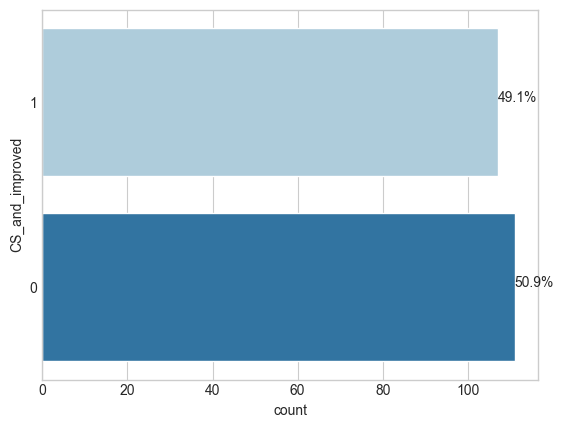

In [7]:
# sns.set_theme(style="whitegrid")

ax = sns.countplot(y="CS_and_improved", data=train_df, alpha=1, palette="Paired")
total = train_df.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

print(train_df.groupby('CS_and_improved').size())
plt.show()


#### Test distribution

CS_and_improved
0    30
1    25
dtype: int64


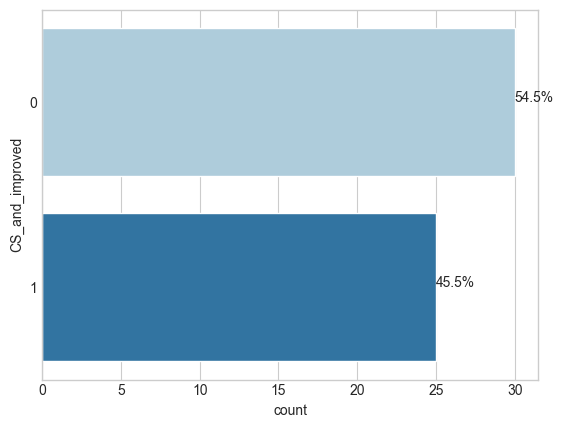

In [8]:
ax = sns.countplot(y="CS_and_improved", data=test_df, alpha=1, palette="Paired")
total = test_df.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

print(test_df.groupby('CS_and_improved').size())
plt.show()

## Feature selection

#### Shap

0.6363636363636364


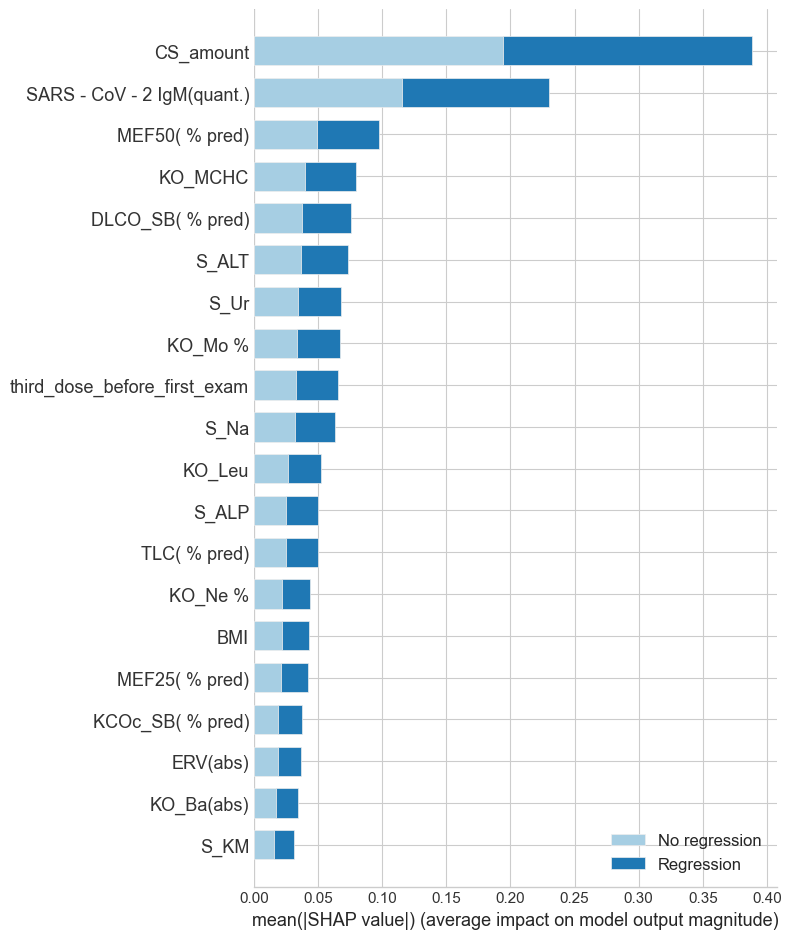

In [16]:
from matplotlib import style

style.use('seaborn-whitegrid')
import matplotlib.pyplot as pl
# plt.style.use('ggplot')


reg = DecisionTreeClassifier(random_state=2)
reg.fit(X_train, y_train)

r2_score = reg.score(X_test, y_test)
print(r2_score)

shap_values = shap.TreeExplainer(reg, ).shap_values(X_test)
shap.summary_plot(shap_values, X_train, class_names=['No regression', 'Regression'], show=False, color=pl.get_cmap("Paired") )
plt.savefig('importance_scatter_dt_clinical_2.pdf', format='pdf', dpi=1200, bbox_inches='tight')

#### K best

In [147]:
fs = SelectKBest(k=25)
fs.fit(all_data_x, all_data_y)

mask = fs.get_support()
new_features = all_data_x.columns[mask]

new_features

Index(['HRCT_interstitial_involvement', 'postcovid_disability', 'CS',
       'CS_amount', 'CS_duration_weeks', 'CS_total', 'hospitalized',
       'remdesivir', 'smoker', 'olfactory_loss', 'EAP', 'comorbidity',
       'VC(abs)', 'FEV1(abs)', 'FVC(abs)', 'PEF(abs)', 'PEF( % pred)',
       'MEF75(abs)', 'TLC(abs)', 'ERV(abs)', 'VA_SB(abs)', 'VIN_SB(abs)',
       'KO_RDW', 'KO_Mo %', 'SARS - CoV - 2 IgM(quant.)'],
      dtype='object')

#### Select features

In [148]:
select_feature = unique(['pneumonia', 'CS_another_problems', 'CS', 'olfactory_loss', 'postcovid_disability',
                         'SARS - CoV - 2 IgG(qualit.)', 'SARS - CoV - 2 IgM(quant.)', 'CS_amount', 'CS_total',
                         'CS_duration_weeks', 'KO_RDW', 'VC(abs)', 'FVC( % pred)', 'FEV1(abs)', 'KO_Mo %',
                         'PEF( % pred)', 'DLCOc_SB(abs)', 'KCO_SB(abs)', 'persistent_cough', 'persistent_dyspnea',
                         'MEF25(abs)',
                         ])

x_train_filtered = X_train[select_feature]
x_test_filtered = X_test[select_feature]